# Pose Approximation

**Notation**:

- B - Batch Size
- N - Number of Points
- H - Height
- W - Width

**Task**:

- Top-Down pose approximation for hands
- rgb image -> 2D coordinates


In [18]:
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [19]:
import torch

class classproperty(property):
    def __get__(self, obj, cls):
        return self.fget(cls)

class Hand:
    # MediaPipe 21 point Hand landmark model: https://mediapipe.readthedocs.io/en/latest/solutions/hands.html
    #        8   12  16  20
    #        |   |   |   |
    #        7   11  15  19
    #    4   |   |   |   |
    #    |   6   10  14  18
    #    3   |   |   |   |
    #    |   5---9---13--17
    #    2    \         /
    #     \    \       /
    #      1    \     /
    #       \    \   /
    #        ------0-
    _RAW_CONNECTIONS = [
        (0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
        (5,6), (5,9), (6,7), (7,8), (9,10), (9,13),
        (10,11), (11,12), (13,14), (13,17), (14,15),
        (15,16), (17,18), (18,19), (19,20)
    ]

    NUM_POINTS = 21
    NUM_FEATURES = 2 # x, y only
    
    @classproperty
    def anatomical(cls):
        # Create the edge list and make it undirected by adding reverse connections (same for all graphs)
        temp = []
        for a, b in cls._RAW_CONNECTIONS:
            temp.append([a, b])
            temp.append([b, a])  # Add the reverse connection
        return temp
    
    @classproperty
    def inverse_anatomical(cls):
        inverse_graph_connections = []
        for i in range(21):
            for j in range(21):
                conn = (i, j)
                if conn not in cls._RAW_CONNECTIONS and i != j:
                    inverse_graph_connections.append(conn)
        return inverse_graph_connections
    
    @staticmethod
    def compute_edge_index(connection_choice):
        return torch.tensor(connection_choice, dtype=torch.long).t().contiguous()

Hand.compute_edge_index(Hand.anatomical)

tensor([[ 0,  1,  0,  5,  0, 17,  1,  2,  2,  3,  3,  4,  5,  6,  5,  9,  6,  7,
          7,  8,  9, 10,  9, 13, 10, 11, 11, 12, 13, 14, 13, 17, 14, 15, 15, 16,
         17, 18, 18, 19, 19, 20],
        [ 1,  0,  5,  0, 17,  0,  2,  1,  3,  2,  4,  3,  6,  5,  9,  5,  7,  6,
          8,  7, 10,  9, 13,  9, 11, 10, 12, 11, 14, 13, 17, 13, 15, 14, 16, 15,
         18, 17, 19, 18, 20, 19]])

In [20]:
import os
import json
from typing import Literal

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from torch.utils.data import random_split, DataLoader

IMAGE_SIZE = 224

dataset_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(), # (Channel, Height, Width)
])

class FreiHand(Dataset):
    """
    Format:
        - `x` - images (B, 224, 224, 3)
        - `y` - ground truth vertices for hand landmarks (B, 21, 2)
    """
    def __init__(self, set_name: Literal["training", "evaluation"], transform=None):
        self.transform = transform
        self.set_name = set_name
        self.BASE_PATH = "/kaggle/input/freihand" if self.set_name == "training" else "/kaggle/input/freihand-reloaded"

        # Load "y"
        with open(os.path.join(self.BASE_PATH, "%s_K.json" % self.set_name), "r") as f:
            K_list = json.load(f)
        with open(os.path.join(self.BASE_PATH, "%s_xyz.json" % self.set_name), "r") as f:
            xyz_list = json.load(f)
        assert len(K_list) == len(xyz_list), "Size mismatch."
        K, xyz = np.array(K_list), np.array(xyz_list)
        uv = np.matmul(xyz, np.swapaxes(K, -1, -2))
        uv = uv / uv[..., 2:3]
        uv = uv / (IMAGE_SIZE-1) * 2 - 1
        self.coords = torch.from_numpy(uv[..., :2].astype(np.float32))

    def __len__(self):
        return self.coords.shape[0]

    def __getitem__(self, idx):
        # NOTE: different versions of the same images are available if you add LEN of datatset to index below (they periodically follow each other)
        img_path = os.path.join(self.BASE_PATH, self.set_name, "rgb", "%08d.jpg" % idx)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.coords[idx]

In [21]:
import warnings

dataset = FreiHand("training", transform=dataset_transforms)
test_dataset = FreiHand("evaluation", transform=dataset_transforms)

train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

BATCH_SIZE = 256
if len(dataset) % BATCH_SIZE != 0 or len(test_dataset) % BATCH_SIZE != 0:
    warnings.warn(f"dataset size is not divisible by BATCH_SIZE -> last batch will be dropped")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2, drop_last=True)

images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

/tmp/ipykernel_39/3073428393.py:13: UserWarning: dataset size is not divisible by BATCH_SIZE -> last batch will be dropped
  warnings.warn(f"dataset size is not divisible by BATCH_SIZE -> last batch will be dropped")


torch.Size([256, 3, 224, 224]) torch.Size([256, 21, 2])


In [22]:
it = iter(train_loader)
%time _ = next(it)

CPU times: user 90.1 ms, sys: 194 ms, total: 284 ms
Wall time: 1.28 s


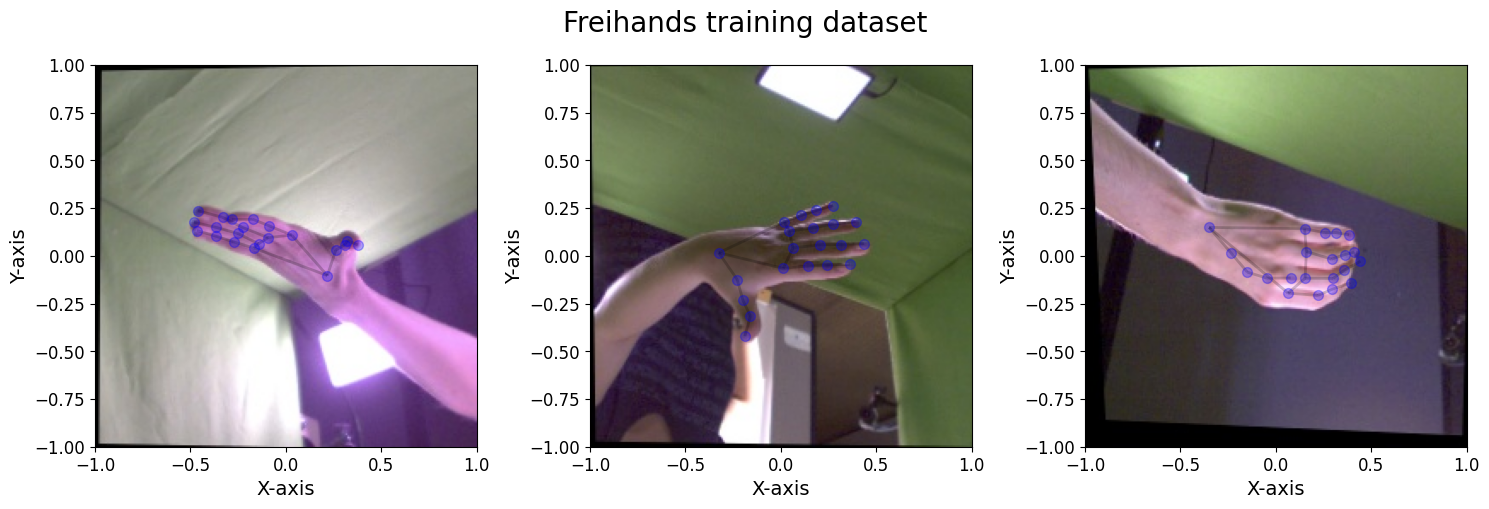

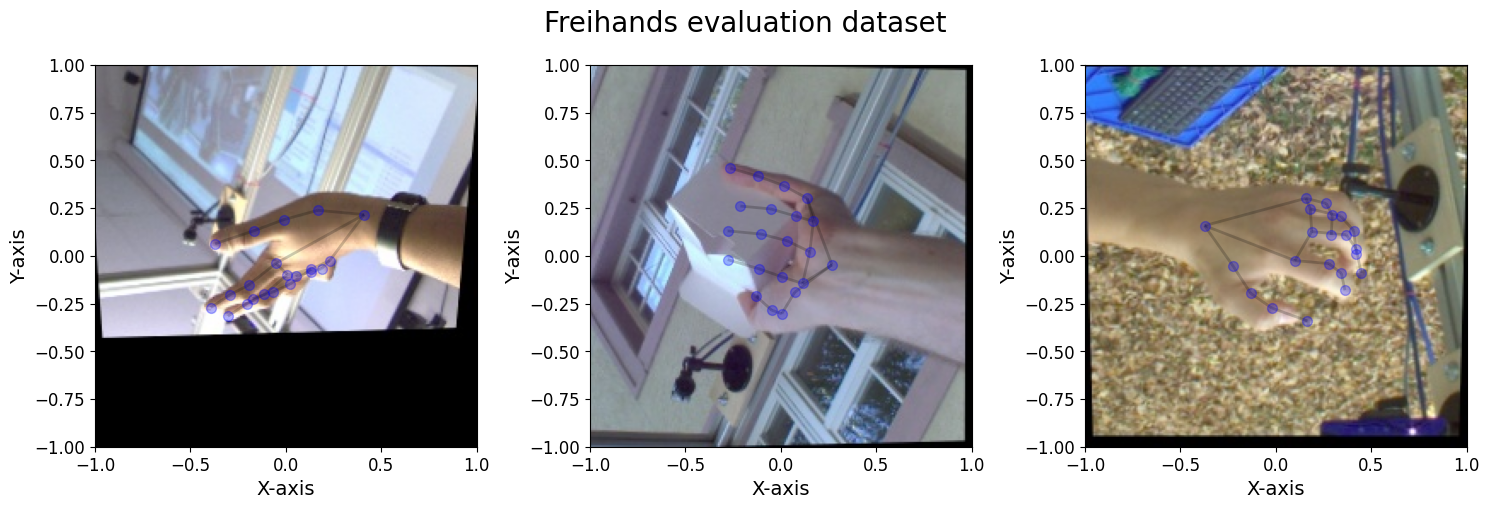

In [23]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from typing import Optional, Callable

from torch.utils.data import Dataset

def visualize_graphs_side_by_side(dataset: Dataset, indices: list[int], model_inference: Optional[Callable] = None):
    num_graphs = len(indices)
    fig, axs = plt.subplots(1, num_graphs, figsize=(5 * num_graphs, 5))
    axs = [axs] if num_graphs == 1 else axs

    fig.suptitle(f"Freihands {dataset.set_name} dataset", fontsize=20)

    for ax, idx in zip(axs, indices):
        img, lms = dataset[idx]
        if model_inference is not None:
            preds = model_inference(img)
        img, lms = img.permute(1, 2, 0).numpy(), lms.numpy()

        # Background image (fit to 0-1 coordinate space)
        ax.imshow(img, extent=[-1, 1, 1, -1], origin='upper', aspect='auto')

        # Graph edges
        edge_index = Hand.compute_edge_index(Hand.anatomical).numpy()
        G = nx.Graph()
        G.add_edges_from(edge_index.T)

        # Node features
        x, y = lms[:, 0], lms[:, 1]
        pos_x = {i: (x[i], y[i]) for i in range(len(x))}
        nx.draw_networkx_nodes(G, pos_x, node_size=50, node_color='blue', alpha=0.3, ax=ax)
        if model_inference is None:
            nx.draw_networkx_edges(G, pos_x, width=2.0, alpha=0.2, ax=ax)

        # Display predictions
        if model_inference is not None:
            x, y = preds[:, 0], preds[:, 1]
            pos_x = {i: (x[i], y[i]) for i in range(len(x))}
            nx.draw_networkx_nodes(G, pos_x, node_size=50, node_color='red', alpha=0.4, ax=ax)
            nx.draw_networkx_edges(G, pos_x, width=1.5, alpha=0.2, ax=ax)

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        # ax.invert_yaxis()
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=12)
        ax.set_xlabel("X-axis", fontsize=14)
        ax.set_ylabel("Y-axis", fontsize=14)

    plt.tight_layout()
    plt.show()

# Example usage
random_indices = random.sample(range(len(dataset)), 3)
visualize_graphs_side_by_side(dataset, indices=random_indices)
random_indices = random.sample(range(len(test_dataset)), 3)
visualize_graphs_side_by_side(test_dataset, indices=random_indices)

# Utils

In [87]:
import torch
import warnings


def _warn_if_out_of_range(name: str, tensor: torch.Tensor, lo: float, hi: float):
    """Issue a warning if any values fall outside [lo, hi]."""
    if torch.any((tensor < lo) | (tensor > hi)):
        bad = tensor[(tensor < lo) | (tensor > hi)]
        warnings.warn(
            f"{name} contains values outside the expected range "
            f"[{lo}, {hi}]. Example offending values: {bad[:5].tolist()}",
            RuntimeWarning
        )


def normalize_coords(coords: torch.Tensor, *, height: int, width: int) -> torch.Tensor:
    """
    Normalize pixel coordinates to [-1, 1].

    Args:
        coords: (B, N, 2) tensor with (x, y) in pixel coordinates [0, W-1], [0, H-1]
        height: height of the heatmap
        width: width of the heatmap
    """
    x = coords[..., 0]
    y = coords[..., 1]

    # warnings
    _warn_if_out_of_range("x pixel coords", x, 0, width - 1)
    _warn_if_out_of_range("y pixel coords", y, 0, height - 1)

    x_norm = (x / (width - 1)) * 2 - 1
    y_norm = (y / (height - 1)) * 2 - 1

    return torch.stack([x_norm, y_norm], dim=-1)


def denormalize_coords(coords: torch.Tensor, *, height: int, width: int) -> torch.Tensor:
    """
    Convert normalized [-1, 1] coordinates back to pixel coordinates.

    Args:
        coords: (B, N, 2) tensor with coordinates in [-1, 1]
        height: height of the heatmap
        width: width of the heatmap
    """
    x = coords[..., 0]
    y = coords[..., 1]

    # warnings
    _warn_if_out_of_range("normalized x coords", x, -1.0, 1.0)
    _warn_if_out_of_range("normalized y coords", y, -1.0, 1.0)

    x_px = ((x + 1) / 2) * (width - 1)
    y_px = ((y + 1) / 2) * (height - 1)

    return torch.stack([x_px, y_px], dim=-1)


B, N = 2, 3
H, W = 56, 56

# Some random pixel coordinates
coords = torch.tensor([[[0, 0], [28, 28], [55, 55]],
                       [[10, 20], [30, 40], [50, 50]]], dtype=torch.float)

coords_norm = normalize_coords(coords, height=H, width=W)
coords_back = denormalize_coords(coords_norm, height=H, width=W)

print("Original coords:\n", coords)
print("Normalized coords:\n", coords_norm)
print("Back to pixels:\n", coords_back)

Original coords:
 tensor([[[ 0.,  0.],
         [28., 28.],
         [55., 55.]],

        [[10., 20.],
         [30., 40.],
         [50., 50.]]])
Normalized coords:
 tensor([[[-1.0000, -1.0000],
         [ 0.0182,  0.0182],
         [ 1.0000,  1.0000]],

        [[-0.6364, -0.2727],
         [ 0.0909,  0.4545],
         [ 0.8182,  0.8182]]])
Back to pixels:
 tensor([[[ 0.,  0.],
         [28., 28.],
         [55., 55.]],

        [[10., 20.],
         [30., 40.],
         [50., 50.]]])


In [89]:
import torch
import torch.nn.functional as F


def argmax_2d(heatmaps: torch.Tensor):
    """
    Compute keypoints using spatial argmax.

    Args:
        heatmaps: (B, N, H, W)

    Returns:
        x, y: tensors of shape (B, N)
    """
    B, N, H, W = heatmaps.shape
    flat = heatmaps.view(B, N, -1) # (B, N, H*W)
    idx = flat.argmax(dim=2)       # (B, N)

    y = (idx // W).float()
    x = (idx % W).float()
    return x, y


def softargmax_2d(heatmaps: torch.Tensor):
    """
    Compute keypoints using softargmax over spatial dims.

    Args:
        heatmaps: (B, N, H, W)

    Returns:
        x, y: tensors of shape (B, N)
    """
    B, N, H, W = heatmaps.shape

    # Softmax over spatial dimension
    flat = heatmaps.view(B, N, -1)
    probs = F.softmax(flat, dim=2).view(B, N, H, W)

    # Coordinate grids
    xs = torch.arange(W, device=heatmaps.device, dtype=heatmaps.dtype)
    ys = torch.arange(H, device=heatmaps.device, dtype=heatmaps.dtype)
    grid_x, grid_y = torch.meshgrid(xs, ys, indexing="xy")  # (W, H)
    # grid_y[h, w] = h (row index repeated across each row)
    # grid_x[h, w] = w (column index repeated across each column)

    # Reshape to (1,1,H,W)
    grid_x = grid_x.unsqueeze(0).unsqueeze(0)
    grid_y = grid_y.unsqueeze(0).unsqueeze(0)

    x = (probs * grid_x).sum(dim=(2, 3))
    y = (probs * grid_y).sum(dim=(2, 3))
    return x, y

# Create a heatmap tensor
B, N, H, W = 1, 2, 10, 12
heatmaps = torch.zeros((B, N, H, W))

# Put peaks at two known positions
peak1 = (3, 5)   # y=3, x=5
peak2 = (7, 2)

heatmaps[0, 0, peak1[0], peak1[1]] = 10.0
heatmaps[0, 1, peak1[0], peak1[1]] = 10.0
heatmaps[0, 1, peak2[0], peak2[1]] = 8.0

print("Heatmaps shape:", heatmaps.shape)

# --- Argmax test ---
x_arg, y_arg = argmax_2d(heatmaps)
pred1 = (x_arg[0,0].item(), y_arg[0,0].item())
assert pred1 == (5.0, 3.0)
pred2 = (x_arg[0,1].item(), y_arg[0,1].item())
assert pred2 == (5.0, 3.0)

# --- Softargmax test ---
# Add some noise so softargmax actually computes something smooth
heatmaps_noisy = heatmaps + 0.05 * torch.randn_like(heatmaps)

x_soft, y_soft = softargmax_2d(heatmaps_noisy)
print("\nSoftargmax results:")
print("Approx (x,y):")
print(f"Keypoint 1: x={x_soft[0,0].item()}, y={y_soft[0,0].item()}")
print(f"Keypoint 2: x={x_soft[0,1].item()}, y={y_soft[0,1].item()}") # <- should be closer to (5,3) than (7,2)

Heatmaps shape: torch.Size([1, 2, 10, 12])

Softargmax results:
Approx (x,y):
Keypoint 1: x=5.002875804901123, y=3.008497714996338
Keypoint 2: x=4.649245262145996, y=3.4778034687042236


# Models

In [90]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total}")
    print(f"Non-Trainable parameters: {total- trainable}")
    return total, trainable

In [91]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

class MobileGNNConv(nn.Module):
    """Custom implementation of GCNConv in Pytorch for Static ASL Fingerspelling sign classification.

    The implementation optimizes the general GCN by making the adjacency matrix, denoted 'A', fixed in size for classic batching.
    It also allows for optimizing the values of said matrix via gradient descent and dynamically freezing the weights.

    Parameters:
    -----------
    input_dim : int
        Dimension of input node features.
    output_dim : int
        Dimension of output node features.
    random_init : bool, default=False
        If True, initializes the adjacency matrix randomly instead of using the anatomical prior.
    optimize_adjacency : bool, default=False
        If True, allows the adjacency matrix to be trainable via gradient descent. Can also be set later via utility func.
    """
    def __init__(self, input_dim: int, output_dim: int, random_init: bool = False, optimize_adjacency: bool = False):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lin = nn.Linear(input_dim, output_dim, bias=False)

        A = torch.zeros((Hand.NUM_POINTS, Hand.NUM_POINTS))
        for x, y in Hand.anatomical:
          A[x, y] = 1

        A_hat = A + torch.eye(A.size(0)) # self loops
        D = torch.diag(A_hat.sum(dim=1))
        D_neg_sqrt = torch.linalg.inv(torch.sqrt(D))
        A_norm = D_neg_sqrt @ A_hat @ D_neg_sqrt
        self.A_norm = nn.Parameter(A_norm, requires_grad=False)

        # Init Adjacency Mx randomly instead of anatomically
        if random_init:
            self.A_norm = nn.Parameter(torch.empty(Hand.NUM_POINTS, Hand.NUM_POINTS), requires_grad=False)
            nn.init.kaiming_uniform_(self.A_norm, a=math.sqrt(5))

        if optimize_adjacency:
            self.set_adjancency(trainable=True)

    def set_adjancency(self, *, trainable: bool):
        self.A_norm.requires_grad = trainable

    def forward(self, X: torch.Tensor):
        # Original formula from paper: ReLU(D^-1/2 * A_hat * D^-1/2 * X * W)
        # Original formula in code: F.relu(self.lin(self.A_norm @ X))
        # NOTE: ReLU was removed, because initial input is small and multiplied with the scarse Adjancency mx -> ReLu zeros out many
        # Could also use F.leaky_relu(self.lin(self.A_norm @ X), negative_slope=0.01)
        return self.lin(self.A_norm @ X)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.input_dim) + ' -> ' + str(self.output_dim) + ')'


inp = torch.zeros(100, Hand.NUM_POINTS, Hand.NUM_FEATURES)
new_num_featrues = 3
test_gnn = MobileGNNConv(Hand.NUM_FEATURES, new_num_featrues)
display(test_gnn)
count_parameters(test_gnn)
f"{inp.shape} -> {test_gnn(inp).shape}"

MobileGNNConv (2 -> 3)

Total parameters: 447
Non-Trainable parameters: 441


'torch.Size([100, 21, 2]) -> torch.Size([100, 21, 3])'

In [92]:
from typing import Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights

class Backbone(nn.Module):
    def __init__(self, backbone_type: Literal["resnet18", "mobilenet_v3"], frozen: bool=False, heatmap=False):
        super(Backbone, self).__init__()

        self.backbone_type = backbone_type
        if self.backbone_type == "mobilenet_v3":
            self.backbone = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1, progress=False)
        elif self.backbone_type == "resnet18":
            self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1, progress=False)
        else:
            raise Exception("Invalid backbone")

        if frozen:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.heatmap = heatmap
        if self.heatmap:
            self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        self.out_features = self.backbone.forward(torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)).shape[1]

    def __repr__(self):
        return f"{self.__class__.__name__}({self.backbone_type}, heatmap: {self.heatmap}, out: {self.out_features})"

    def forward(self, x: torch.Tensor):
        """
        Args:
            x: (Batch, Channels, H, W)

        Returns:
            tensor: (Batch, out_features) if self.heatmap==True else (Batch, out_features, H_grid, W_grid)
        """
        return self.backbone(x)

test_backbone = Backbone("resnet18", heatmap=False)
inp = torch.randn(16, 3, IMAGE_SIZE, IMAGE_SIZE)
display(test_backbone)
count_parameters(test_backbone)
f"{inp.shape} -> {test_backbone(inp).shape}"

Backbone(resnet18, heatmap: False, out: 1000)

Total parameters: 11689512
Non-Trainable parameters: 0


'torch.Size([16, 3, 224, 224]) -> torch.Size([16, 1000])'

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PoseModel(nn.Module):
    """Base class for pose approximation tasks.

    This class defines the skeleton for a pose estimation model. It provides
    methods for performing forward inference and computing keypoints from the
    raw model output.

    Methods:
        forward(x: torch.Tensor) -> torch.Tensor:
            Defines the computation performed at every call.
        compute_keypoints(out: torch.Tensor) -> torch.Tensor:
            Converts model output into keypoint coordinates.
        inference(x: torch.Tensor) -> torch.Tensor:
            Runs a forward pass and computes keypoints in a single call.
    """
    def __init__(self):
        super().__init__()

    def compute_keypoints(self, out: torch.Tensor) -> torch.Tensor:
        """Computes keypoints from the model output.

        Args:
            out (torch.Tensor): Raw output from forward method.

        Returns:
            torch.Tensor: Keypoint coordinates, shape (B, N, 2)
        """
        return out

    def inference(self, x: torch.Tensor) -> torch.Tensor:
        """Runs a full inference pass: forward + keypoint computation.

        Args:
            x (torch.Tensor): Input tensor

        Returns:
            torch.Tensor: Computed keypoints, shape (B, N, 2)
        """
        out = self.forward(x)
        keypoints = self.compute_keypoints(out)
        return keypoints


In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class KeypointModel(PoseModel):
    def __init__(self, backbone: Backbone):
        super().__init__()

        self.backbone = backbone

        # Linear neck
        self.neck = nn.Linear(self.backbone.out_features, Hand.NUM_POINTS * Hand.NUM_FEATURES)

        # GNN head
        exp_dim = Hand.NUM_FEATURES
        self.gnn1 = MobileGNNConv(Hand.NUM_FEATURES, exp_dim, random_init=True, optimize_adjacency=True)
        self.gnn2 = MobileGNNConv(exp_dim, Hand.NUM_FEATURES, random_init=True, optimize_adjacency=True)
 
    def forward(self, x: torch.Tensor):
        """
        Args:
            x: (Batch, Channels, Height, Width)

        Returns:
            tensor: (Batch, Points, Coords)
        """
        B = x.size(0)
        x = self.backbone(x)
        x = self.neck(x)
        x = x.view(B, Hand.NUM_POINTS, Hand.NUM_FEATURES)
        x = self.gnn1(x) + x # residual conn only works with exp_dim == Hand.NUM_FEATURES
        x = self.gnn2(x) + x
        return x

test_pose_model = KeypointModel(Backbone("resnet18"))
inp = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
display(test_pose_model)
count_parameters(test_pose_model)
print(f"forward: {inp.shape} -> {test_pose_model(inp).shape}")
print(f"inference: {inp.shape} -> {test_pose_model.inference(inp).shape}")

KeypointModel(
  (backbone): Backbone(resnet18, heatmap: False, out: 1000)
  (neck): Linear(in_features=1000, out_features=42, bias=True)
  (gnn1): MobileGNNConv (2 -> 2)
  (gnn2): MobileGNNConv (2 -> 2)
)

Total parameters: 11732444
Non-Trainable parameters: 0
forward: torch.Size([1, 3, 224, 224]) -> torch.Size([1, 21, 2])
inference: torch.Size([1, 3, 224, 224]) -> torch.Size([1, 21, 2])


In [97]:
from typing import Literal

import torch
import torch.nn as nn
import torch.nn.functional as F

class HeatmapModel(PoseModel):
    def __init__(self, backbone: Backbone, readout: Literal["argmax", "softargmax"]):
        super().__init__()

        self.readout = readout

        self.backbone = backbone

        self.channels = 256
        self.head = nn.Sequential(
            nn.Conv2d(self.backbone.out_features, self.channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(self.channels, self.channels, kernel_size=4, stride=2, padding=1),  # 7→14
            nn.BatchNorm2d(self.channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(self.channels, self.channels, kernel_size=4, stride=2, padding=1),  # 14→28
            nn.BatchNorm2d(self.channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(self.channels, self.channels, kernel_size=4, stride=2, padding=1),  # 28→56
            nn.BatchNorm2d(self.channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(self.channels, Hand.NUM_POINTS, kernel_size=1)
        )

        # remember heatmap dimensions
        self.H_, self.W_ = 56, 56

    def compute_keypoints(self, heatmaps: torch.Tensor):
        """
        Compute keypoints from predicted heatmaps.

        Args:
            heatmaps: (B, N, H', W') predicted heatmaps
            method: "argmax" or "softargmax"

        Returns:
            keypoints: (B, N, 2) tensor with (x, y) coordinates
        """
        B, N, H_, W_ = heatmaps.shape
        assert H_ == self.H_ and W_ == self.W_

        if self.readout == "argmax":
            x, y = argmax_2d(heatmaps)
        elif self.readout == "softargmax":
            x, y = softargmax_2d(heatmaps)
        else:
            raise ValueError(f"Unknown method: {method}")

        # IMPORTANT: Keypoints were computed in heatmap coordinates
        # normalize between [-1, 1] (scale of the heatmap won't matter this way)
        keypoints = torch.stack([x, y], dim=-1) # (B, N, 2)
        keypoints = normalize_coords(keypoints, height=H_, width=W_) # [-1, 1]
        return keypoints

    def forward(self, x: torch.Tensor):
        """
        Args:
            x: (B, Channels, H, W)

        Returns:
            heatmaps: (B, N, H', W')
        """
        B, C, H, W = x.shape[0], x.shape[1], x.shape[2], x.shape[3]
        x = self.backbone(x)
        x = self.head(x)
        x = torch.softmax(x.view(B, Hand.NUM_POINTS, -1), dim=-1).view(B, Hand.NUM_POINTS, self.H_, self.W_)
        return x

test_heatmap_model = HeatmapModel(Backbone("resnet18", heatmap=True), readout="softargmax")
inp = torch.randn(16, 3, IMAGE_SIZE, IMAGE_SIZE)
display(test_heatmap_model)
count_parameters(test_heatmap_model)
print(f"forward: {inp.shape} -> {test_heatmap_model(inp).shape}")
print(f"inference: {inp.shape} -> {test_heatmap_model.inference(inp).shape}")

HeatmapModel(
  (backbone): Backbone(resnet18, heatmap: True, out: 512)
  (head): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
  )
)

Total parameters: 15510357
Non-Trainable parameters: 0
forward: torch.Size([16, 3, 224, 224]) -> torch.Size([16, 21, 56, 56])
inference: torch.Size([16, 3, 224, 224]) -> torch.Size([16, 21, 2])


In [98]:
from typing import Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

class HeatmapLoss(nn.Module):
    def __init__(self, loss_type: Literal["mse", "kl"]):
        """
        Args:
            smoothing (float): Standard deviation of the Gaussian (in heatmap pixel units).
        """
        super().__init__()
        self.sigma = 1.5 # sigma for gaussian
        self.loss_type = loss_type

    def _create_target_heatmaps(self, coords, *, height, width):
        """
        Create Gaussian heatmaps from normalized coordinates.

        Args:
            coords: (B, N, 2) normalized: [-1, 1]
            height: of heatmap
            width: of heatmap

        Returns:
            target_heatmaps: (B, N, H, W)
        """
        H, W = height, width
        device = coords.device

        # Convert from [-1,1] to pixel coordinates [0, W/H)
        # Note: (-1,-1) → (0,0), (+1,+1) → (W-1,H-1)
        coords_px = denormalize_coords(coords, height=H, width=W)

        # Prepare meshgrid
        y = torch.arange(H, device=device).view(1, 1, H, 1)
        x = torch.arange(W, device=device).view(1, 1, 1, W)

        # Expand for broadcasting
        mu_x = coords_px[..., 0].unsqueeze(-1).unsqueeze(-1)  # (B,N,1,1)
        mu_y = coords_px[..., 1].unsqueeze(-1).unsqueeze(-1)

        # Compute Gaussian
        heatmaps = torch.exp(
            -((x - mu_x)**2 + (y - mu_y)**2) / (2 * self.sigma**2)
        )

        return heatmaps

    def forward(self, pred_heatmaps, gt_coords):
        """
        Args:
            pred_heatmaps: (B, N, H, W) expected to represent a probability distribution
            gt_coords: (B, N, 2) normalized : [-1, 1]
        Returns:
            scalar loss (batch mean)
        """
        B, N, H, W = pred_heatmaps.shape
        target_heatmaps = self._create_target_heatmaps(gt_coords, (H, W))

        if self.loss_type == "mse":
            # Peak normalization for both target and pred heatmaps (gaussians can be arbitrarily large)
            target_heatmaps = target_heatmaps / (target_heatmaps.amax(dim=(-2, -1), keepdim=True) + 1e-6)
            pred_heatmaps = pred_heatmaps / (pred_heatmaps.amax(dim=(-2,-1), keepdim=True) + 1e-6)
            loss = F.mse_loss(pred_heatmaps, target_heatmaps)
        elif self.loss_type == "kl":
            # Kullback–Leibler Divergence Loss
            pred_prob = F.softmax(pred_heatmaps.view(B, N, -1), dim=-1) # create distribution with softmax for model output logits
            target_prob = target_heatmaps.view(B, N, -1)
            target_prob = target_prob / (target_prob.sum(dim=-1, keepdim=True) + 1e-6) # create distribution with simply dividing by sum -> to not distort gaussian
            loss = F.kl_div(pred_prob.log(), target_prob, reduction="batchmean")

        return loss

tensor([[[36., 28.],
         [36., 29.],
         [34., 27.],
         [31., 27.],
         [27., 27.],
         [28., 26.],
         [24., 26.],
         [21., 26.],
         [17., 26.],
         [26., 27.],
         [22., 27.],
         [19., 28.],
         [15., 28.],
         [26., 29.],
         [22., 29.],
         [19., 29.],
         [16., 29.],
         [26., 30.],
         [24., 30.],
         [21., 30.],
         [19., 30.]]])


/tmp/ipykernel_39/239067597.py:9: RuntimeWarning: x pixel coords contains values outside the expected range [0, 11]. Example offending values: [36.0, 36.0, 34.0, 31.0, 27.0]
  warnings.warn(
/tmp/ipykernel_39/239067597.py:9: RuntimeWarning: y pixel coords contains values outside the expected range [0, 9]. Example offending values: [28.0, 29.0, 27.0, 27.0, 27.0]
  warnings.warn(
/tmp/ipykernel_39/239067597.py:9: RuntimeWarning: normalized x coords contains values outside the expected range [-1.0, 1.0]. Example offending values: [5.545454502105713, 5.545454502105713, 5.181818008422852, 4.636363506317139, 3.909090995788574]
  warnings.warn(
/tmp/ipykernel_39/239067597.py:9: RuntimeWarning: normalized y coords contains values outside the expected range [-1.0, 1.0]. Example offending values: [5.222222328186035, 5.44444465637207, 5.0, 5.0, 5.0]
  warnings.warn(


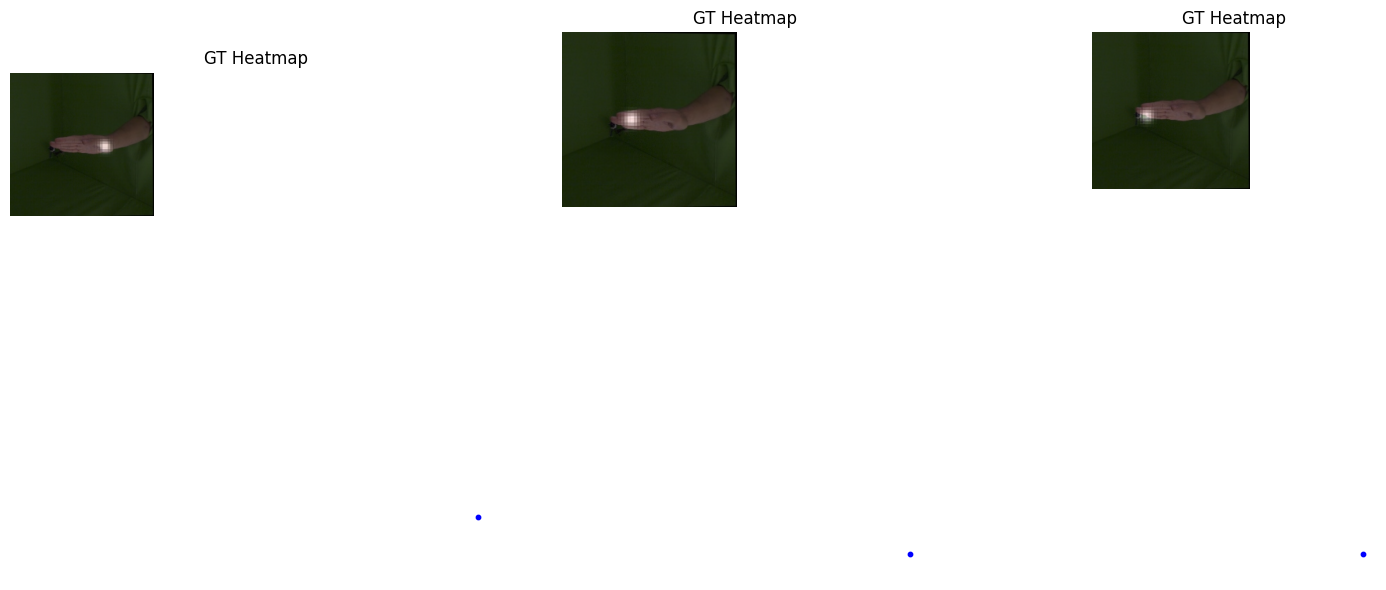

In [101]:
import random
from typing import Callable, Optional

import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_heatmaps(
    dataset: FreiHand,
    heatmap_loss: HeatmapLoss,
    heatmap_model: Optional[HeatmapModel] = None
):
    # Load one example from the dataset
    image, gt_coords = random.choice(dataset)
    gt_coords = gt_coords.unsqueeze(0)
    
    # Either show model results or ground truth generated by loss
    with torch.no_grad():
        if heatmap_model is None:
            H_, W_ = 56, 56
            heatmaps = heatmap_loss._create_target_heatmaps(gt_coords, height=H_, width=W_)
            x, y = argmax_2d(heatmaps)
            coords = torch.stack([x, y], dim=-1)
            print(coords)
            normalized_keypoints = normalize_coords(coords, height=H, width=W)
        else:
            heatmaps = heatmap_model.forward(image.unsqueeze(0))
            normalized_keypoints = heatmap_model.compute_keypoints(heatmaps)
    
    def show_heatmap_overlay(img_tensor, heatmap):
        alpha = 0.6
        img_np = img_tensor.permute(1, 2, 0).numpy()
        heat_np = heatmap.numpy()
        heat_np = (heat_np - heat_np.min()) / (heat_np.max() - heat_np.min() + 1e-8)
        heat_np = np.stack([heat_np]*3, axis=-1)
        overlay = (1 - alpha) * img_np + alpha * heat_np
        return np.clip(overlay, 0, 1)
    
    num_joints_to_show = 3
    indices = np.linspace(0, gt_coords.shape[1]-1, num_joints_to_show, dtype=int)
    fig, axes = plt.subplots(1, num_joints_to_show, figsize=(15, 6))
    for i, j_idx in enumerate(indices):
        gt_hm = heatmaps[0, j_idx:j_idx+1]  # select appropriate heatmap for keypoint

        # Upscale heatmap to image resolution using nearest-neighbor (pixelated)
        gt_hm_up = F.interpolate(gt_hm.unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode="nearest")[0, 0]
        gt_overlay = show_heatmap_overlay(image, gt_hm_up)
        axes[i].imshow(gt_overlay)
        
        # Convert normalized coords [-1,1] to pixel coordinates
        pixel_coords = denormalize_coords(normalized_keypoints, height=IMAGE_SIZE, width=IMAGE_SIZE)
        x_px = pixel_coords[0, j_idx, 0]
        y_px = pixel_coords[0, j_idx, 1]
        axes[i].scatter(x_px, y_px, c='blue', s=10)

        axes[i].set_title("GT Heatmap")
        axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_heatmaps(
    dataset=dataset,
    heatmap_loss=HeatmapLoss(loss_type="kl"),
    # heatmap_model=HeatmapModel(Backbone("resnet18", heatmap=True), readout="softargmax")
)

In [118]:
import torch


def pck(preds, targets, threshold=0.05):
    """
    Computes Correct Keypoints within a tolerance

    Args:
        pred: predicted keypoints, shape (num_points, coords)
        gt: ground-truth keypoints, shape (num_points, coords)

    Returns:
        scalar: Percentage of correct keypoints
    """
    dists = torch.norm(preds - targets, dim=-1)
    correct = (dists < threshold).float()
    return correct.mean().item()


def mpjpe(pred: torch.Tensor, gt: torch.Tensor) -> torch.Tensor:
    """
    Mean Per Joint Position Error (MPJPE)
    
    Args:
        pred: predicted keypoints, shape (num_points, coords)
        gt: ground-truth keypoints, shape (num_points, coords)
    
    Returns:
        scalar tensor: mean Euclidean distance per joint
    """
    return torch.norm(pred - gt, dim=1).mean().item()


def n_mpjpe(pred: torch.Tensor, gt: torch.Tensor) -> torch.Tensor:
    """
    Normalized MPJPE (after Procrustes alignment for scale and translation)
    
    Args:
        pred: predicted keypoints, shape (num_points, coords)
        gt: ground-truth keypoints, shape (num_points, coords)
    
    Returns:
        scalar tensor: MPJPE after scaling alignment
    """
    # Center both sets
    pred_centered = pred - pred.mean(dim=0, keepdim=True)
    gt_centered = gt - gt.mean(dim=0, keepdim=True)
    
    # Optimal scale
    scale = (pred_centered * gt_centered).sum() / (pred_centered ** 2).sum()
    
    # Apply scale
    pred_aligned = pred_centered * scale
    
    # Compute MPJPE after alignment
    return mpjpe(pred_aligned, gt_centered)


# Example usage:
num_points = 5
coords = 3
pred = torch.rand(num_points, coords)
gt = torch.rand(num_points, coords)

print("PCK: ", pck(pred, gt))
print("MPJPE:", mpjpe(pred, gt))
print("N-MPJPE:", n_mpjpe(pred, gt))


PCK:  0.0
MPJPE: 0.5806543231010437
N-MPJPE: 0.3123461604118347


In [140]:
import torch.optim as optim
from tqdm.notebook import tqdm

def train_pose_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, criterion: nn.Module, optimizer, epochs=2, device="cuda"):
    model = model.to(device)

    def run_epoch(loader, training=True):
        model.train() if training else model.eval()
        metrics = { "LOSS": 0.0, "PCK": 0.0, "MPJPE": 0.0, "N-MPJPE": 0.0 }

        with torch.set_grad_enabled(training):
            for imgs, targets in tqdm(loader, "Training" if training else "Validating"):
                inputs, targets = imgs.to(device), targets.to(device)

                if training:
                    optimizer.zero_grad()

                preds = model(inputs)
                loss = criterion(preds, targets)

                if training:
                    loss.backward()
                    optimizer.step()

                # For Heatmap models only
                if model.is_heatmap_model:
                    preds = argmax2d(preds)

                metrics["LOSS"] += loss.item()
                metrics["PCK"] += pck(preds, targets)
                metrics["MPJPE"] += mpjpe(preds, targets)
                metrics["N-MPJPE"] += n_mpjpe(preds, targets)

        num_batches = len(loader)
        # Average the metrics
        # NOTE: assuming batches with identical size
        metrics = {k: v / num_batches for k, v in metrics.items()}
        return metrics

    for epoch in range(1, epochs + 1):
        train_metrics = run_epoch(train_loader, training=True)
        print(f"[Epoch {epoch}] Train | " +
              ", ".join(f"{k}: {v:.4f}" for k, v in train_metrics.items()))
        
        val_metrics = run_epoch(val_loader, training=False)
        print(f"         Val   | " +
              ", ".join(f"{k}: {v:.4f}" for k, v in val_metrics.items()) + "\n")


model, criterion = PoseHeatmapModel(Backbone("resnet18", heatmap=True)), PoseHeatmapLoss(sigma=1.5, loss_type="kl")
#model, criterion = PoseModel(Backbone("resnet18")), nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)
device = "cuda" if torch.cuda.is_available() else "cpu"
train_pose_model(model, train_loader, valid_loader, criterion, optimizer, epochs=2, device=device)

Training:   0%|          | 0/114 [00:00<?, ?it/s]

[Epoch 1] Train | LOSS: 0.0403, PCK: 0.0657, MPJPE: 0.9179, N-MPJPE: 0.7934


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

         Val   | LOSS: 0.0398, PCK: 0.1069, MPJPE: 0.7971, N-MPJPE: 0.7336



Training:   0%|          | 0/114 [00:00<?, ?it/s]

[Epoch 2] Train | LOSS: 0.0389, PCK: 0.2033, MPJPE: 0.6008, N-MPJPE: 0.5672


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

         Val   | LOSS: 0.0381, PCK: 0.2859, MPJPE: 0.4827, N-MPJPE: 0.4655



In [141]:
from functools import partial

def inference(img, model):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    image = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred_lms = model(image)
    pred_lms = pred_lms.cpu()
    return pred_lms[0]

model_inference = partial(inference, model=model)
model_inference(test_dataset[0][0]).shape

torch.Size([21, 56, 56])

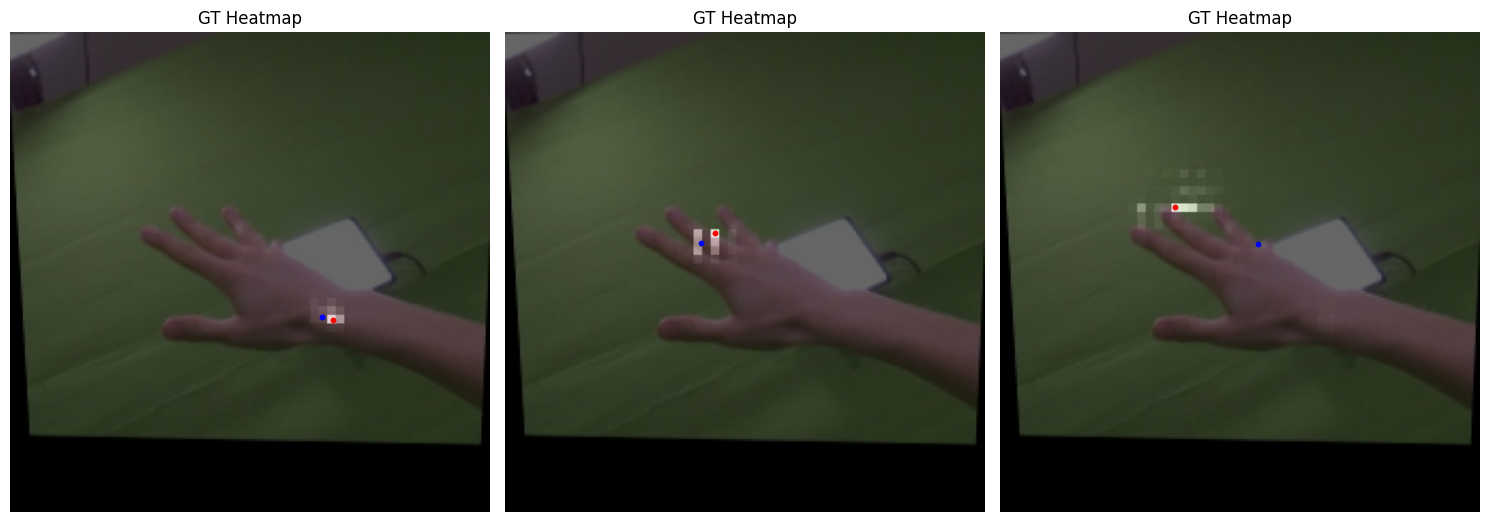

In [142]:
visualize_heatmaps(dataset, alpha=0.6, model_inference=model_inference)

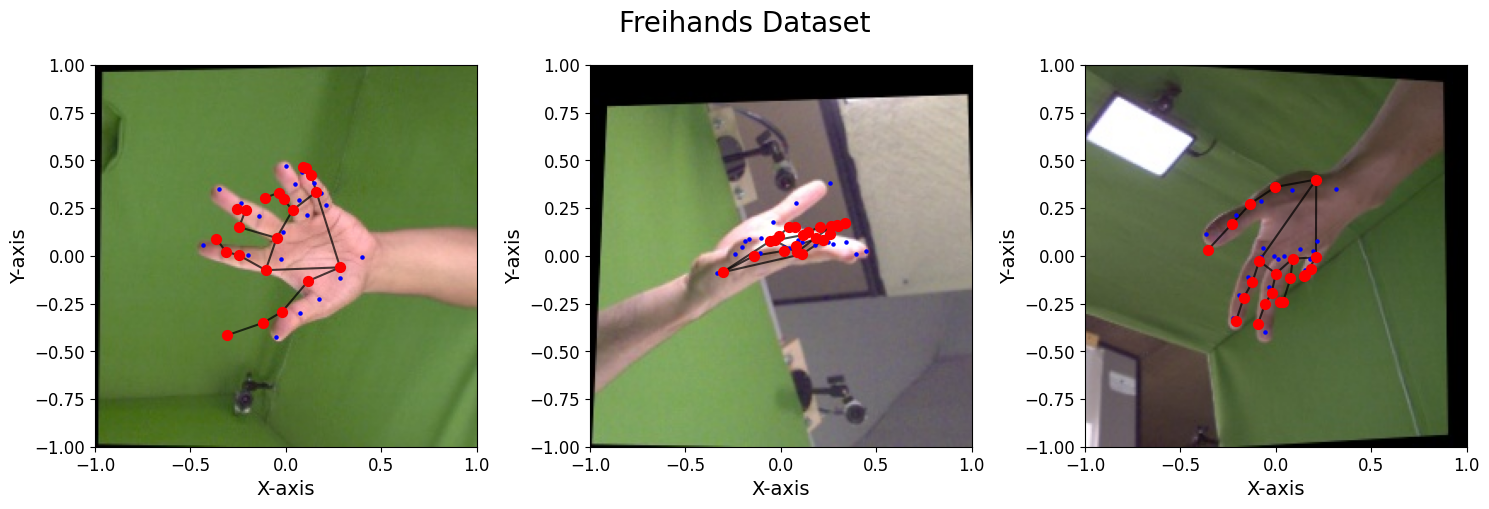

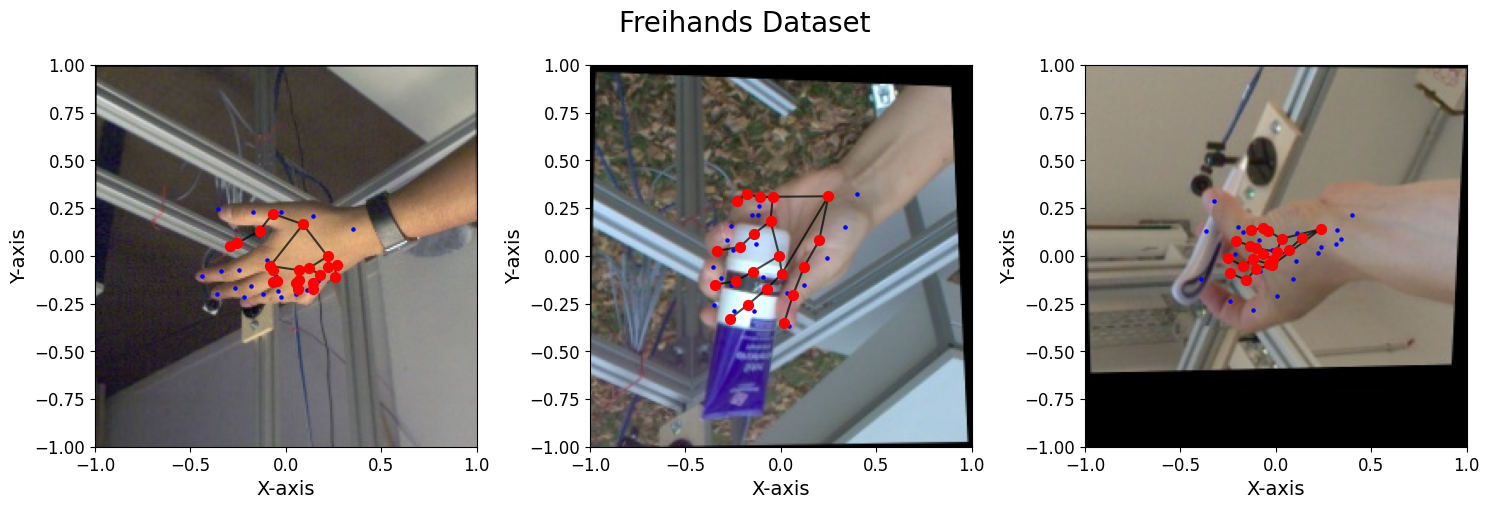

In [118]:
random_indices = random.sample(range(len(dataset)), 3)
visualize_graphs_side_by_side(dataset, random_indices, model_inference)
random_indices = random.sample(range(len(test_dataset)), 3)
visualize_graphs_side_by_side(test_dataset, random_indices, model_inference)